This notebook shows how to visualize the intermediate attention masks of a TbD-net on the CLEVR dataset.

In [1]:
from pathlib import Path

import torch
import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

from tbd.module_net import load_tbd_net
from utils.clevr import load_vocab
from utils.download_pretrained_models import download

Define a function to wrap `torch.autograd.Variable` to automatically use the GPU when CUDA is available

In [2]:
def Variable(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return torch.autograd.Variable(tensor)

Load the vocabulary dictionary, which holds mappings from question, answer, and program tokens to indices. Then load a pre-trained Transparency by Design network (TbD-Net) from a checkpoint.

*Note*: if you do not have the checkpoint downloaded, running this cell will download it.

In [3]:
vocab = load_vocab(Path('data/vocab.json'))

model_path = Path('./models')
tbd_net_checkpoint = 'clevr-reg-hres.pt'
if not (model_path / tbd_net_checkpoint).exists():
    download(tbd_net_checkpoint)
    
tbd_net = load_tbd_net(model_path / tbd_net_checkpoint, vocab)

Helper functions and variables

In [4]:
def forward_input(module_name, in1, in2):
    ''' Send `in1` and `in2` through the `module_name` module. 
    
    Parameters
    ----------
    module_name : str
        The module to forward input through.
        
    in1 : torch.autograd.Variable
        The first input.
        
    in2 : torch.autograd.Variable
        The second input.
        
    Returns
    -------
    torch.autograd.Variable
        The output of the operation `module_name` when given `in1` and `in2`.
    '''
    return tbd_net.function_modules[module_name](in1, in2)

def attn_var_to_np(attn):
    ''' Convenience function to take an input `Variable` and convert to a NumPy array.
    
    Parameters
    ----------
    attn : torch.autograd.Variable
        The attention mask `Variable` to convert to a NumPy array.
        
    Returns
    -------
    numpy.ndarray
        An array of shape (r, c) containing the data from `attn`.
    '''
    return attn.data.cpu().numpy().squeeze()

def display_helper(ax, attn, title='', interp='lanczos'):
    ''' Convenience function to plot an attention on a set of axes.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The set of axes on which to display the attention.
        
    attn : numpy.ndarray, shape (r, c)
        The attention mask to display.
        
    title : str, optional (default='')
        The title to display over the plot.
    
    interp : str, optional (default='lanczos')
        The type of interpolation to use. In our paper, we use lanczos interpolation
        for the smoothed images and nearest for the rest of our visualizations.
        Legal options are: (‘nearest’, ‘lanczos’, ‘bilinear’, ‘bicubic’, ‘cubic’).
    '''
    interp = interp if interp else 'nearest'
    ax.imshow(imresize(attn, (224, 224), interp))
    ax.axis('off')
    ax.set_title(title);

## Count, Figure 1
Question: How many large metal cylinders are in the image?

Prediction: 2


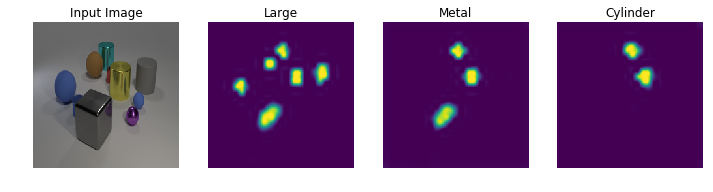

In [5]:
# read in the data
img = plt.imread(str(Path('data/test_im_000054.png')))
feat = np.load(Path('data/test_feats_000054.npy'))

# convert to PyTorch tensor
feat_var = Variable(torch.FloatTensor(feat))

# forward through the network
scene_input = tbd_net.stem(feat_var)
large_filter = forward_input('filter_size[large]', scene_input, tbd_net.ones_var)
metal_filter = forward_input('filter_material[metal]', scene_input, large_filter)
cylinder_filter = forward_input('filter_shape[cylinder]', scene_input, metal_filter)

# display the image and attention masks
fig, axs = plt.subplots(1, 4, figsize=(12,4))
display_helper(axs[0], img, 'Input Image')
display_helper(axs[1], attn_var_to_np(large_filter), 'Large')
display_helper(axs[2], attn_var_to_np(metal_filter), 'Metal')
display_helper(axs[3], attn_var_to_np(cylinder_filter), 'Cylinder')

# compute and print the prediction
count_output = forward_input('count', scene_input, cylinder_filter)
final_output = tbd_net.classifier(count_output)
_, prediction = final_output.max(1)
print('Prediction: {}'.format(vocab['answer_idx_to_token'][prediction.item()]))

## Figure 3
Question: What color is the big object that is left of the large metal sphere and right of the green metal thing?

Prediction: red


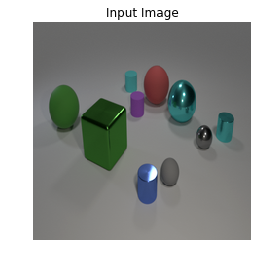

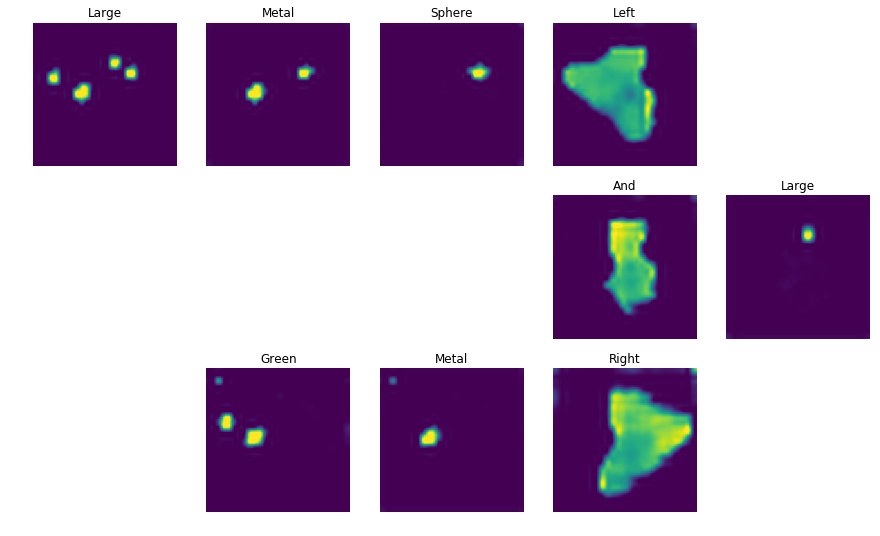

In [6]:
# read in the data
img = plt.imread(str(Path('data/test_im_000012.png')))
feat = np.load(Path('data/test_feats_000012.npy'))

# convert to PyTorch tensor
feat_var = Variable(torch.FloatTensor(feat))

# forward through the network
scene_input = tbd_net.stem(feat_var)

# forward through the first logical series
large_filter = forward_input('filter_size[large]', scene_input, tbd_net.ones_var)
metal_filter = forward_input('filter_material[metal]', scene_input, large_filter)
sphere_filter = forward_input('filter_shape[sphere]', scene_input, metal_filter)
left_filter = forward_input('relate[left]', scene_input, sphere_filter)

# forward through the second logical series
green_filter = forward_input('filter_color[green]', scene_input, tbd_net.ones_var)
metal2_filter = forward_input('filter_material[metal]', scene_input, green_filter)
right_filter = forward_input('relate[right]', scene_input, metal2_filter)

# forward through the third logical series
and_filter = forward_input('intersect', left_filter, right_filter)
large2_filter = forward_input('filter_size[large]', scene_input, and_filter)

# display the input image and attention masks
_, ax = plt.subplots()
display_helper(ax, img, 'Input Image')

fig, ((ax00, ax01, ax02, ax03, ax04),
      (ax10, ax11, ax12, ax13, ax14),
      (ax20, ax21, ax22, ax23, ax24)) = plt.subplots(3, 5, figsize=(15, 9))

# row 1: first logical series
display_helper(ax00, attn_var_to_np(large_filter), 'Large')
display_helper(ax01, attn_var_to_np(metal_filter), 'Metal')
display_helper(ax02, attn_var_to_np(sphere_filter), 'Sphere')
display_helper(ax03, attn_var_to_np(left_filter), 'Left')
ax04.remove()

# row 3: second logical series
ax20.remove()
display_helper(ax21, attn_var_to_np(green_filter), 'Green')
display_helper(ax22, attn_var_to_np(metal2_filter), 'Metal')
display_helper(ax23, attn_var_to_np(right_filter), 'Right')
ax24.remove()

# row 2: third logical series
ax10.remove()
ax11.remove()
ax12.remove()
display_helper(ax13, attn_var_to_np(and_filter), 'And')
display_helper(ax14, attn_var_to_np(large2_filter), 'Large')

# compute and print the prediction
color_output = forward_input('query_color', scene_input, large2_filter)
final_output = tbd_net.classifier(color_output)
_, prediction = final_output.max(1)
print('Prediction: {}'.format(vocab['answer_idx_to_token'][prediction.item()]))

## Metal filter, Figure 6
No question; this is meant to illustrate that the `Attention` operations behave intuitively

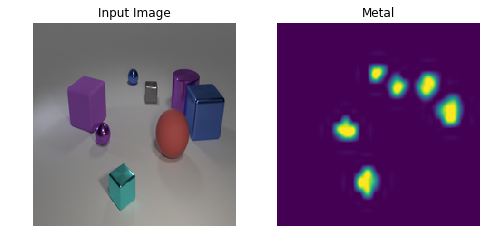

In [7]:
# read in the data
img = plt.imread(str(Path('data/test_im_000021.png')))
feat = np.load(Path('data/test_feats_000021.npy'))

# convert to PyTorch tensor
feat_var = Variable(torch.FloatTensor(feat))

# forward through the network
scene_input = tbd_net.stem(feat_var)
metal_filter = forward_input('filter_material[metal]', scene_input, tbd_net.ones_var)

# display the image and attention mask
fig, axs = plt.subplots(1, 2, figsize=(8,4))
display_helper(axs[0], img, 'Input Image')
display_helper(axs[1], attn_var_to_np(metal_filter), 'Metal')

## Relate[right], Figure 7
No question; this is meant to illustrate that the `Relate` operations, while more complex than the `Attention` operations, are equally sensible and intuitive

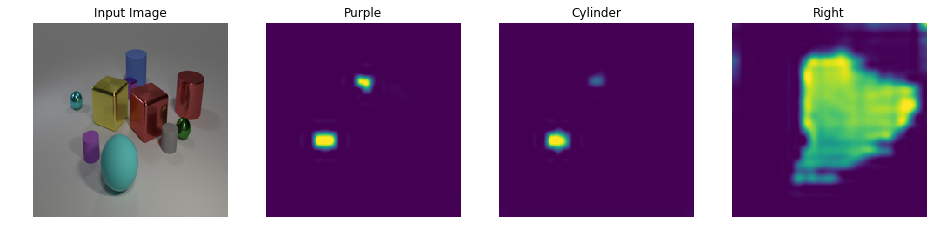

In [8]:
# read in the data
img = plt.imread(str(Path('data/test_im_000027.png')))
feat = np.load(Path('data/test_feats_000027.npy'))

# convert to PyTorch tensor
feat_var = Variable(torch.FloatTensor(feat))

# forward through the network
scene_input = tbd_net.stem(feat_var)
purple_filter = forward_input('filter_color[purple]', scene_input, tbd_net.ones_var)
cylinder_filter = forward_input('filter_shape[cylinder]', scene_input, purple_filter)
right_filter = forward_input('relate[right]', scene_input, cylinder_filter)

# display the image and attention masks
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
display_helper(axs[0], img, 'Input Image')
display_helper(axs[1], attn_var_to_np(purple_filter), 'Purple')
display_helper(axs[2], attn_var_to_np(cylinder_filter), 'Cylinder')
display_helper(axs[3], attn_var_to_np(right_filter), 'Right')

## Same[color], Figure 8
No question; this is meant to illustrate that the `Same` operations, while being quite complex, are as sensible and intuitive as the `Relate` and `Attention` operations

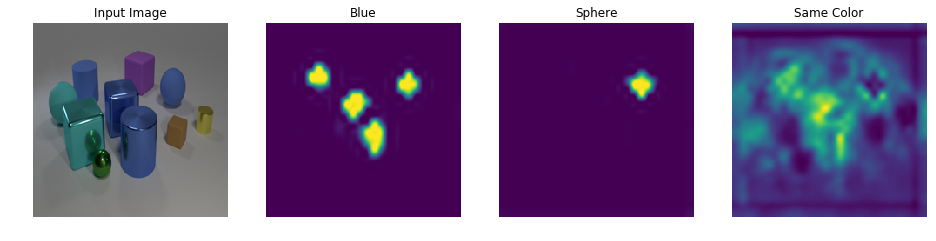

In [9]:
# read in the data
img = plt.imread(str(Path('data/test_im_000024.png')))
feat = np.load(Path('data/test_feats_000024.npy'))

# convert to PyTorch tensor
feat_var = Variable(torch.FloatTensor(feat))

# forward through the network
scene_input = tbd_net.stem(feat_var)
blue_filter = forward_input('filter_color[blue]', scene_input, tbd_net.ones_var)
sphere_filter = forward_input('filter_shape[sphere]', scene_input, blue_filter)
same_color = forward_input('same_color', scene_input, sphere_filter)

# display the image and attention masks
fig, axs = plt.subplots(1, 4, figsize=(16,4));
display_helper(axs[0], img, 'Input Image')
display_helper(axs[1], attn_var_to_np(blue_filter), 'Blue')
display_helper(axs[2], attn_var_to_np(sphere_filter), 'Sphere')
display_helper(axs[3], attn_var_to_np(same_color), 'Same Color')